# TSFS12 Hand-in Exercise 5: Learning for autonomous vehicles --- Reinforcement learning and Q-learning

Q-learning for solving an extension of Example 6.6 in
Sutton, R. S., & A. G. Barto: Reinforcement learning: An introduction.
MIT Press, 2018.

Initial imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from seaborn import despine
from grid_world import plot_value_and_policy, p_grid_world

In [2]:
%matplotlib inline
# Run if you want plots in external windows
# %matplotlib

# Define the parameters for the Markov Decision Process

In [3]:
gamma = 0.99   # Discount factor
R_goal = 0.0   # Reward for reaching goal state
R_sink = -10.0   # Reward for reaching 'cliff' states
R_grid = -0.1   # Reward for remaining states

alpha = 0.5   # Learning rate in Q-update
eps = 0.5   # Epsilon-greedy parameter

P_move_action = 1.0  # Probability of moving in the direction specified by action
P_dist = (1 - P_move_action) / 2  # Probability of moving sideways compared to 
                                  # intended because of disturbance

# Define size of grid world, goal, and cliff states
n_rows = 4
n_cols = 5

goal = (3, 4)  # Element index goal state
sink = [(3, 1), (3, 2), (3, 3)]  # Element indices for cliff states

# Setup reward matrix R
R = np.full((n_rows, n_cols), fill_value=R_grid)
R[goal[0], goal[1]] = R_goal
for p in sink:
    R[p[0], p[1]] = R_sink

# Occupancy grid defines states where there are obstacles (0 - no
# obstacles, 1 - obstacles)
occ_grid = np.zeros((n_rows, n_cols))
occ_grid[1, 1] = 1

# Save parameters in a dictionary
params = {'gamma': gamma, 'R_goal': R_goal, 'R_sink': R_sink,
          'alpha': alpha, 'eps': eps,
          'R_grid': R_grid, 'P_move_action': P_move_action, 
          'P_dist': P_dist, 'n_rows': n_rows, 'n_cols': n_cols, 
          'goal': goal, 'sink': sink, 'R': R, 'occ_grid': occ_grid}

# Auxiliary function used in the main loop for Q-learning

In [4]:
rg = np.random.default_rng(seed=1891)  # Random number generator used when simulating actions

# Function for computing the next state s_prim and its associated reward
def next_state(s, a, params):
    p_next_state = p_grid_world(s, a, params)
    s_prim, r, _ = p_next_state[rg.choice(range(len(p_next_state)), p=[p_i[2] for p_i in p_next_state])]
    return s_prim, r

# Epsilon-greedy exploration function

In [5]:
def select_eps_greedy(s_curr, itr_nbr, Q, params):
    """Select the action to take at a particular state s_curr using 
      an epsilon-greedy strategy
    
      action = select_eps_greedy(s_curr, k, Q, params):
      
      Input:
          s_curr - current state
          itr_nbr - current iteration number
          Q - Q matrix
          params - parameter dictionary
          
      Output:
          action - selected action
    """
    
    # Constant epsilon over episodes
    eps = params['eps']

    # Sample a number between 0 and 1, select action based on the outcome
    rnd = np.random.uniform()
    
    # Find the best action according to current Q at state s_curr
    max_a = np.argmax(Q[s_curr[0], s_curr[1]])

    # Create vector with remaining actions
    a_list = []
    for a in range(4):
        if not a == max_a:
            a_list.append(a)

    # Select action according to sampled random value
    if rnd < 1 - eps + eps / 4:
        action = max_a
    elif rnd < 1 - eps + eps / 2:
        action = a_list[0]
    elif rnd < 1 - eps + 3 * eps / 4:
        action = a_list[1]
    else:
        action = a_list[2]
        
    return action

# Main loop for Q-learning

Initialize the main learning loop

In [6]:
# Initialize variable for value function V for each state s
V = np.zeros((n_rows, n_cols))

# Initialize object for Q-function with random values (function of
# state s and action a)
Q = np.random.uniform(size=(n_rows, n_cols, 4))  # Number of rows x number of columns x number 
                                                 # of actions

# Initialize Q for terminal states to zero
Q[goal[0], goal[1]] = 0.0
for si in sink:
    Q[si[0], si[1]] = 0.0
    
# Initialize vector for policy Pi
# Actions - ['left', 'right', 'up', 'down'] counted as 0-3
Pi = np.full((n_rows, n_cols), fill_value=-1)

# Define number of iterations for Q-learning
nbr_iters = 2000

# Initialize vector for sum of rewards for each episode
sum_r = np.zeros(nbr_iters)

Algorithm according to Section 6.5 in Sutton, R. S., & A. G. Barto: 
Reinforcement learning: An introduction. MIT Press, 2018.

In [7]:
converged = False
# Run nbr_iters episodes of Q-learning
for k in range(nbr_iters):
    # Start state
    s_curr = (n_rows - 1, 0)
    
    terminal_state = False
    
    # Continue Q-learning episode until terminal state reached
    while not terminal_state:
        # Select action according to epsilon-greedy strategy
        action = select_eps_greedy(s_curr, k, Q, params)
        
        # Perform the action and receive reward and next state s_prim
        s_prim, r = next_state(s_curr, action, params)

        # Q-learning update of action-value function
        Q[s_curr[0], s_curr[1], action] = (
            Q[s_curr[0], s_curr[1], action] + 
            alpha * (r + gamma * np.max(Q[s_prim[0], s_prim[1]]) - 
            Q[s_curr[0], s_curr[1], action]))
        
        # Update the sum of reward vector
        sum_r[k] = sum_r[k] + r
        
        # Move to next state
        s_curr = s_prim
        
        # Check if a terminal state has been reached (goal or sink states, 
        # closes an episode)
        if s_curr == goal or s_curr in sink:
            terminal_state = True
            
            # Update value function V and policy Pi
            for row in range(n_rows):
                for col in range(n_cols):
                    if (occ_grid[row, col] == 1) or (row, col) == goal or (row, col) in sink:
                        continue
                    # Compute value function V at current state from Q
                    # function
                    max_a = np.argmax(Q[row, col])
                    V_ij = Q[row, col, max_a]
                    V[row, col] = V_ij
                    # Update policy Pi with the currently best action at
                    # current state (according to Q function)
                    Pi[row, col] = max_a

Visualize the value function and policy after all iterations

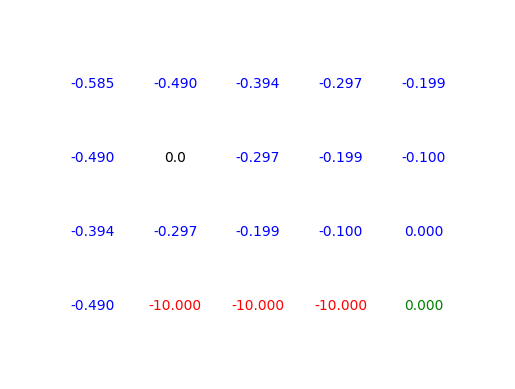

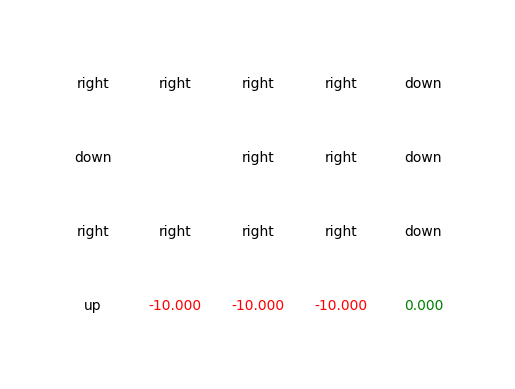

In [8]:
plot_value_and_policy(V, Pi, params)

Compute average of reward for N episodes for smoothing

In [ ]:
N = 40
mean_sum_r = np.zeros(sum_r.shape[0])

for k in range(N, sum_r.shape[0]):
    mean_sum_r[k] = np.mean(sum_r[k - N:k])

Visualize the evolution of the reward for each episode

In [ ]:
plt.figure(3, clear=True)
plt.plot(mean_sum_r[N:], lw=0.5)
plt.title(f'Sum of rewards for each episode (average over {N})')
despine()